## EJECUTA ESTA CELDA PARA AUTENTICARTE CON TU CUENTA DE GMAIL


In [ ]:
!sudo /opt/miniconda/bin/pip install httplib2 apiclient oauth2client==1.5.2 ntplib tzlocal gspread google-api-python-client==1.6.2

In [1]:
from mooclib import *
import inspect, urllib
html, auth_code, userinfo = google_authenticate(PORT_NUMBER=8080)
html

CLICK ON THIS LINK TO AUTHENTICATE WITH YOUR GMAIL ACCOUNT
https://accounts.google.com/o/oauth2/auth?scope=profile+email&redirect_uri=http%3A%2F%2Flocalhost%3A8080&response_type=code&client_id=486275613361-7nk9ktukfcfjevfoe3tamjp0pmbjmprs.apps.googleusercontent.com&access_type=offline
waiting for authentication ...
code=4/ewDxuXYY_1kK-U87l8vH3gK4jlPEdVR8b-YGQnX4zqyIJfAMF2j9BSlI0vdwxk2SwPpgSx4VIAHlulkPrg6T5as&scope=https://www.googleapis.com/auth/userinfo.profile%20https://www.googleapis.com/auth/userinfo.email
No authentication


ejecuta esta celda para que sus funciones estén disponible en el problemset.

In [5]:
from sklearn.datasets import *
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt
%matplotlib inline

def plot_2Ddata_with_boundary(predict,X,y):
    n = 200
    mins,maxs = np.min(X,axis=0), np.max(X,axis=0)
    mins -= np.abs(mins)*.2
    maxs += np.abs(maxs)*.2
    d0 = np.linspace(mins[0], maxs[0],n)
    d1 = np.linspace(mins[1], maxs[1],n)
    gd0,gd1 = np.meshgrid(d0,d1)
    D = np.hstack((gd0.reshape(-1,1), gd1.reshape(-1,1)))
    p = (predict(D)*1.).reshape((n,n))
    plt.contourf(gd0,gd1,p, levels=[-0.1,0.5], alpha=0.5, cmap=plt.cm.Greys)
    plt.scatter(X[y==0][:,0], X[y==0][:,1], c="blue")
    plt.scatter(X[y==1][:,0], X[y==1][:,1], c="red")


## Ejercicio 1: Características polinomiales

Completa la función `map_features` para expandir X con características polinomiales según la variable de clase `self.pols`, creando un conjunto de columnas nuevo elevando las originales con cada elemento de `self.pols`. Por ejemplo, si `self.pols`
 es `[2,5]`, la expansión de
 
      1  2
      3  2
      2  1
      
sería

      1  2  1  4   1   32
      3  2  9  4  243  32
      2  1  4  1   32   1
      
completa el resto de las funciones de la clase `LR` según el problemset de la lección anterior correspondiente, usando la aproximación basade en regresión logística (con $g$ como función sigmoide).

$$J(\theta) = \frac{1}{m}\sum_{i=0}^{m-1} (y^{(i)}-g(\mathbf{x}^{(i)}\theta))^2$$ 

observa que $\mathbf{X}$ ahora se refiere al dataset con (1) una columna de unos añadida; y (2) la expansión de características polinomiales

In [4]:
def LR(**args): # hack for inspect to work with classes
    from scipy.optimize import minimize
    import numpy as np
    
    class LR_class:
        
        def __init__(self, pols):
            self.pols = pols
        
        def map_features(self, X):
            # np.hstack([X**p for p in [1]+self.pos])
            rX = X
            for pol in self.pols:
                rX = np.c_[rX, X**pol]
                
            return rX
        

        def fit(self, X, y):
            X = np.hstack((np.ones((len(X),1)), X))
            X = self.map_features(X)
            
            def cost(t):
                return np.mean((y - self.g(X.dot(t)))**2)
                             
            r = minimize(cost, np.ones(X.shape[1])*-.11+np.random.random(X.shape[1])*.1, method="BFGS")
            self.theta = r.x  

        def predict(self, X):
            X = np.hstack((np.ones((len(X),1)), X))
            X = self.map_features(X)
            return (self.g(X.dot(self.theta))>0.5)*1

        def g(self, X):
            return 1/(1+np.exp(-X))

        def score(self, X,y):
            return np.sum(self.predict(X)==y)*1./len(X)
        
    return LR_class(**args)

import urllib, inspect
src1 = urllib.quote_plus(inspect.getsource(LR))

comprueba tu código

In [5]:
import numpy as np
X = np.array([[1, 2], [3,2], [2,1]])
lr = LR(pols=[2,5])
lr.map_features(X)

array([[  1,   2,   1,   4,   1,  32],
       [  3,   2,   9,   4, 243,  32],
       [  2,   1,   4,   1,  32,   1]])

observa las fronteras de clasificación que se generan

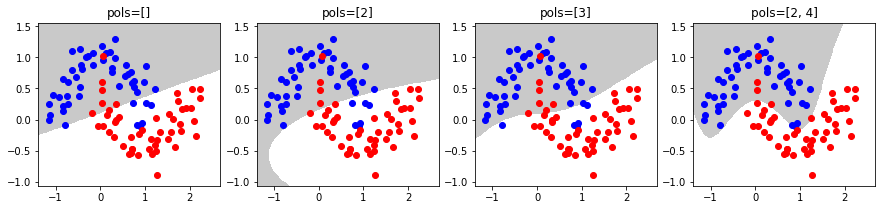

In [6]:
data = np.loadtxt("data/logregdata.csv", delimiter=",", skiprows=1)
X,y = data[:,:2], data[:,2]

plt.figure(figsize=(15,3))

for i,pols in enumerate([[], [2], [3], [2,4]]):
    plt.subplot(1,4,i+1)
    lr = LR(pols=pols)
    lr.fit(X,y)
    plot_2Ddata_with_boundary(lr.predict, X,y)
    plt.title("pols="+str(list(pols)))
    

#### evaluate your answer before submitting:

In [7]:
!./run CHECK_SOLUTION PS5_1 $src1

evaluation result CORRECT


#### submit your answer (you must be connected to internet)

In [8]:
!./run SUBMIT_SOLUTION PS5_1 $src1

connecting ... registering submission for johanyepes@gmail.com ...
your submissions sheet is https://docs.google.com/spreadsheets/d/1DLd93QfjZBJi20J-SE6-NSKtNaGtvKEawyPD03luawA
----
evaluation result CORRECT , submission registered


## Ejercicio 2: Regularización

Implementa la función de coste y gradiente de aproximación probabilística para regresión logística, pero con regularización:

$$J(\theta) = -l(\theta) = \frac{1}{m}\sum_{i=0}^{m-1}y_i log(g(\mathbf{x}_i\theta))+(1-y_i) log(1-g(\mathbf{x}_i\theta))+ \lambda ||\theta||^2$$

$$\nabla J= \frac{1}{m}2X^{T}\cdot(g(X\cdot\theta)-Y) + 2\lambda||\theta||$$

En donde los argumentos `t` y `reg` representan $\theta$ y $\lambda$ respectivamente. 


In [3]:
def g(X):
    return 1/(1+np.exp(-X))
        
def cost(X, y, t, reg):
    return -np.mean(y*(np.log(g(X.dot(t)))) + (1 - y)*(np.log(1 - g(X.dot(t))))) + reg * np.linalg.norm(t)**2

def grad(X, y, t, reg):
    return 2*X.T.dot(g(X.dot(t)) - y)/len(X) + 2 * reg * np.linalg.norm(t)

import urllib, inspect
src2 = urllib.quote_plus(inspect.getsource(cost)+"\n"+inspect.getsource(grad))


comprueba tu código. el coste y gradientes en la configuración siguiente deben de ser 2.599 y [1.2, 1.65] respectivamente

In [6]:
data = np.loadtxt("data/logregdata.csv", delimiter=",", skiprows=1)
X,y = data[:,:2], data[:,2]

t = np.ones(X.shape[1])*2
reg = 0.2

print "cost", cost(X,y,t,reg)
print "grad", grad(X,y,t,reg)

cost 2.5988381707487447
grad [1.20042017 1.64805227]


#### evaluate your answer before submitting:

In [7]:
!./run CHECK_SOLUTION PS5_2 $src2

evaluation result CORRECT


#### submit your answer (you must be connected to internet)

In [8]:
!./run SUBMIT_SOLUTION PS5_2 $src2

connecting ... user not authenticated, please run the first cell of this notebook to authenticate


## Ejercicio 3: Cross validation

Fíjate cómo funciona un particionador de un dataset para cross validation

In [16]:
from sklearn.cross_validation import KFold
import numpy as np
X = np.random.randint(10, size=(20,2))
from sklearn.tree import DecisionTreeClassifier
#print X
#print "--"
for itr, its in KFold(len(X), 4):
    print "index train", itr, "index test", its
#    print X[itr]
#    print X[its]
        

/opt/miniconda/lib/python2.7/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


index train [ 5  6  7  8  9 10 11 12 13 14 15 16 17 18 19] index test [0 1 2 3 4]
index train [ 0  1  2  3  4 10 11 12 13 14 15 16 17 18 19] index test [5 6 7 8 9]
index train [ 0  1  2  3  4  5  6  7  8  9 15 16 17 18 19] index test [10 11 12 13 14]
index train [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14] index test [15 16 17 18 19]


completa la función siguiente para que dado un estimador, un dataset y un número de _folds_:
    
- itere sobre un `KFold` con los _folds_ especificados y en cada iteración:
    - entrene el estimador con la parte del dataset especificada por los índices de entrenamiento (el dataset de entrenamiento)
    - calcule el score con el dataset de entrenamiento
    - calcule el score con el dataset de test
- finalmente, la función tendrá que devolver la media y desviación estándar de los scores de entrenamiento y test obtenidos durante la iteración.

In [17]:
def crossval_estimator(estimator, X,y, n_folds=5):
    from sklearn.cross_validation import KFold
    sctr, scts = [],[]
    for itr, its in KFold(len(X), n_folds):
        X_train = X[itr]
        y_train = y[itr]
        X_test  = X[its]
        y_test  = y[its]

        estimator.fit(X_train, y_train)
        
        sctr.append(np.mean(estimator.predict(X_train) == y_train))
        scts.append(np.mean(estimator.predict(X_test) == y_test))
    return np.mean(sctr), np.std(sctr), np.mean(scts), np.std(scts)

import urllib, inspect
src3 = urllib.quote_plus(inspect.getsource(crossval_estimator))


Comprueba tu código, debería de darte una curva como esta en la que se ve el impacto de variar un parámetro del estimador

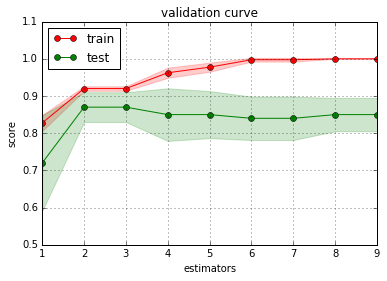

In [26]:
from IPython.display import Image
Image(filename='imgs/dt-depth.png')

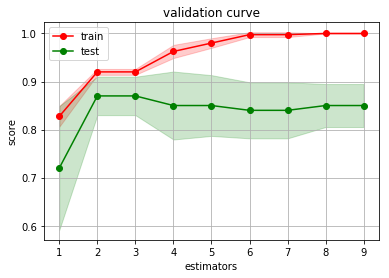

In [18]:
from sklearn.tree import DecisionTreeClassifier

def crossval_estimators(estimators,X,y):
    meanstr, stdstr = [], []
    meansts, stdsts = [], []
    for estimator in estimators:
        mstr, sstr, msts, ssts = crossval_estimator(estimator, X, y, 5)
        meanstr.append(mstr)
        stdstr.append(sstr)
        meansts.append(msts)
        stdsts.append(ssts)

    return [np.array(i) for i in meanstr, meansts, stdstr, stdsts]

data = np.loadtxt("data/logregdata.csv", delimiter=",", skiprows=1)
X,y = data[:,:2], data[:,2]
rngs = range(1,10,1)
estimators = [DecisionTreeClassifier(max_depth=i) for i in rngs]

def plot_cv_estimators(estimators, rngs, X,y):
    meanstr, meansts, stdstr, stdsts = crossval_estimators(estimators,X,y)

    plt.grid()
    plt.plot(rngs, meanstr, "o-", color="red", label="train")
    plt.fill_between(rngs, meanstr-stdstr, meanstr+stdstr, color="red", alpha=.2)

    plt.plot(rngs, meansts, "o-", color="green", label="test")
    plt.fill_between(rngs, meansts-stdsts, meansts+stdsts, color="green", alpha=.2)
    plt.xlabel("estimators")
    plt.ylabel("score")
    plt.legend(loc="best")
    plt.title("validation curve")
    
plot_cv_estimators(estimators, rngs, X,y)

#### evaluate your answer before submitting:

In [19]:
!./run CHECK_SOLUTION PS5_3 $src3

/opt/miniconda/lib/python2.7/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
evaluation result CORRECT


#### submit your answer (you must be connected to internet)

In [20]:
!./run SUBMIT_SOLUTION PS5_3 $src3

connecting ... registering submission for johanyepes@gmail.com ...
/opt/miniconda/lib/python2.7/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
your submissions sheet is https://docs.google.com/spreadsheets/d/1DLd93QfjZBJi20J-SE6-NSKtNaGtvKEawyPD03luawA
----
evaluation result CORRECT , submission registered


## Ejercicio 4: Selección de modelos

Cuando queremos seleccionar o calibrar los parámetros de un modelo debemos de separar una parte del dataset para realizar el proceso de selección y otra parte para medir el desempeño del modelo que se seleccione. De esta manera, evitamos sesgos estadísticos en el desempeño final reportado.

Por tanto, dada una lista de estimadores y un datset:

- Dividimos el dataset en dos partes: una para hacer la selección de modelos (`Xsel`, `ysel`) y otra para medir el desempeño del modelo elegido (`Xtest`, `ytest`)

- Usamos un método de validación sobre `Xsel`/`ysel` sobre cada estimador y obtenemos un score de desempeño para cada uno de ellos. Esto es el **score de validación** de cada estimador. Observa que, dependiendo del método de validación, se crearán a su vez varias particiones de `Xsel`/`ysel` para entrenar y medir la capacidad de generalización de cada estimador.

- Seleccionamos el estimador que tenga el mejor score de validación.

- Entrenamos el estimador seleccionado con **TODOS LOS ELEMENTOS** de `Xsel`/`ysel`

- Medimos el desempeño del estimador con `Xtest`/`ytest`. Observa que esta es la **ÚNICA VEZ** que usamos estos datos.

Completa la función siguiente para que dado una lista de estimadores y las particiones `Xsel`/`ysel` y `Xtest`/`ytest`:

1. Realice un cross validation para cada estimador con `Xsel`/`ysel` y obtenga el promedio de desempeño de 5 folds. Usa la función [`cross_val_score`](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html) y la clase [`KFold`](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html) para el argumento `cv`. 
2. Determine cual es el estimador con mayor score promedio (*best_estimator*)
3. Entrene *best_estimator* con `Xsel`/`ysel`
4. Mida el score de *best_estimator* con `Xtest`/`ytest`
5. Devuelva:
   - *best_estimator*
   - el score  promedio de *best_estimator* en la fase de cross validation
   - el score de *best_estimator* con `Xtest`/`ytest`

In [21]:
def select_model(estimators, Xsel, ysel, Xtest, ytest):
    from sklearn.cross_validation import cross_val_score, KFold
    means=[]
    for estimator in estimators:
        sc = cross_val_score(estimator, Xsel, ysel, cv=KFold(len(Xsel), 5))
        means.append(np.mean(sc))

    best_estimator      = estimators[np.argmax(means)]
    best_crossval_score = max(means)
    best_estimator.fit(Xsel, ysel)
    best_score = best_estimator.score(Xtest, ytest)
    return best_estimator, best_crossval_score, best_score

import urllib, inspect
src4 = urllib.quote_plus(inspect.getsource(select_model))

Comprueba tu código. La siguiente prueba muestrea  Xsel y Xtest y realiza el proceso de selección de modelo 100 veces. En promedio, el mejor `max_depth` debería de ser alrededor de 2.4, el score de cross validacion sobre 0.76 y el score de test sobre 0.74. Como cada vez se genera un dataset nuevo con `make_moons` el proceso es estocástico.

In [31]:
from sklearn.tree import DecisionTreeClassifier
#from sklearn.svm import SVC

data = np.loadtxt("data/logregdata.csv", delimiter=",", skiprows=1)
X,y = data[:,:2], data[:,2]

a = []
n=50
for i in range(100):
    X,y = make_moons(200, noise=.5)
    estimators = [DecisionTreeClassifier(max_depth=i) for i in range(1,5,1)]

    Xs, ys = X[:n], y[:n]
    Xt, yt = X[n:], y[n:]

    best, sc1, sc2 = select_model(estimators, Xs, ys, Xt, yt)
    a.append([sc1, sc2, best.max_depth])
print "scores    cv    test    max_depth"
print "promedios %.3f %.3f   %.3f"%tuple(np.mean(np.array(a), axis=0))
print "stds      %.3f %.3f   %.3f"%tuple(np.std(np.array(a), axis=0))


scores    cv    test    max_depth
promedios 0.781 0.749   2.280
stds      0.075 0.054   0.928


#### evaluate your answer before submitting:

In [32]:
!./run CHECK_SOLUTION PS5_4 $src4

/opt/miniconda/lib/python2.7/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
evaluation result CORRECT


#### submit your answer (you must be connected to internet)

In [24]:
!./run SUBMIT_SOLUTION PS5_4 $src4

connecting ... registering submission for johanyepes@gmail.com ...
/opt/miniconda/lib/python2.7/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
your submissions sheet is https://docs.google.com/spreadsheets/d/1DLd93QfjZBJi20J-SE6-NSKtNaGtvKEawyPD03luawA
----
evaluation result CORRECT , submission registered


## Ejercicio 5: Resampling for learning curve

Fíjate cómo usamos una permutación para escoger aleatoriamente particiones de un vector. Observa que la permutación se usa para indexar los elementos del vector y los elementos escogidos son aleatorios y no se superponen.

In [26]:
#v = np.random.randint(100, size=10)+100
v = np.random.randint(10, size=10)+100
print "Original vector", v
p = np.random.permutation(len(v))
print "Permutation", p
print "6 first elements of permutation", p[:6]
print "3 last elements of permutation ", p[-3:]
print "6 random elements (from the start)", v[p[:6]]
print "3 random elements (from the end)  ", v[p[-3:]]

 Original vector [100 100 100 103 104 104 101 101 103 107]
Permutation [4 8 6 9 0 2 3 5 7 1]
6 first elements of permutation [4 8 6 9 0 2]
3 last elements of permutation  [5 7 1]
6 random elements (from the start) [104 103 101 107 100 100]
3 random elements (from the end)   [104 101 100]


Completa la función siguiente para que, dado un un estimador y un dataset `X/y`, repita `n_reps` veces el siguiente proceso, con `test_size` y `train_size`:

- Escoja aleatoriamente un conjunto de elementos de entrenamiento de `X/y` de según `train_size` (p.ej., 0.2 indica el 20% de los datos)
- Escoja aleatoriamente un conjunto de elementos de test de `X/y` de según `test_size` (p.ej., 0.2 indica el 20% de los datos). Estos datos **han de ser distintos** de los de entrenamiento. Puedes usar la técnica con permutaciones anterior. Asume que `test_size` + `train_size` es menor que 1.
- Entrene el estimador con los elementos de entrenamiento seleccionados
- Calcule el score con los datos de entrenamiento y con los de test

La función ha de devolver dos listas de longitud `n_reps`, una con los scores de entrenamiento obtenidos y otra con los scores de test. Observa que en **cada repetición** hay que muestrear **nuevos** conjuntos de entrenamiento y de test.

In [27]:
def lc_point(estimator, X, y, train_size, test_size, n_reps):

    if train_size + test_size > 1.:
        raise ValueError("train size and test size must add up to 1 or less")
        
    tr_size = int(len(X)*train_size)
    ts_size = int(len(X)*test_size)
    sc_train, sc_test = [], []
    for i in range(n_reps):
        p = np.random.permutation(len(X))

        X_train, y_train = X[p[:tr_size]], y[p[:tr_size]]
        X_test, y_test   = X[p[-ts_size:]], y[p[-ts_size:]]
        
        estimator.fit(X_train, y_train)
        sc_train.append(estimator.score(X_train, y_train))
        sc_test.append(estimator.score(X_test, y_test))
    return sc_train, sc_test

import urllib, inspect
src5 = urllib.quote_plus(inspect.getsource(lc_point))

Comprueba tu código. El promedio con 1000 repeticiones en train y test ha de ser 0.75 y 0.66 aprox.

In [28]:
X,y = make_circles(300, noise=.1)
estimator = DecisionTreeClassifier(max_depth=3)
tr, ts = lc_point(estimator, X, y, .5,.5,1000)
np.mean(tr), np.mean(ts)

(0.7513466666666667, 0.6492133333333334)

#### evaluate your answer before submitting:

In [29]:
!./run CHECK_SOLUTION PS5_5 $src5

evaluation result CORRECT


#### submit your answer (you must be connected to internet)

In [30]:
!./run SUBMIT_SOLUTION PS5_5 $src5

connecting ... registering submission for johanyepes@gmail.com ...
your submissions sheet is https://docs.google.com/spreadsheets/d/1DLd93QfjZBJi20J-SE6-NSKtNaGtvKEawyPD03luawA
----
evaluation result CORRECT , submission registered


**YA ACABASTE EL PROBLEMSET**. Ahora si quieres experimenta con tu código. Las siguientes celdas generan curvas de aprendizaje y muestran fronteras de clasificación con árboles de decisión más y menos complejos y datasets más y menos ruidosos.

In [15]:
from sklearn.linear_model import LogisticRegression

def plot_lc(estimator, X,y, train_sizes, test_size, n_reps=10):
    r = np.array([[np.mean(tr), np.std(tr), np.mean(ts), np.std(ts)] \
                   for tr, ts in [lc_point(estimator, X,y, s,test_size, n_reps) \
                   for s in train_sizes]])

    plt.plot(train_sizes, r[:,0], "o-", color="red", label="train")
    plt.fill_between(train_sizes, r[:,0]-r[:,1], r[:,0]+r[:,1], alpha=.1, color="red")

    plt.plot(train_sizes, r[:,2], "o-", color="green", label="test")
    plt.fill_between(train_sizes, r[:,2]-r[:,3], r[:,2]+r[:,3], alpha=.1, color="green")
    plt.legend(loc="best")
    plt.ylim(0,1.05); plt.xlim(train_sizes[0]*.80,train_sizes[-1]*1.05); plt.grid()
    plt.xticks(train_sizes, [int(s*len(X)) for s in train_sizes])
    plt.yticks(np.linspace(0,1,11));
    plt.xlabel("train set size")
    plt.title("learning curve for test size "+str(test_size))
    plt.ylabel("score")

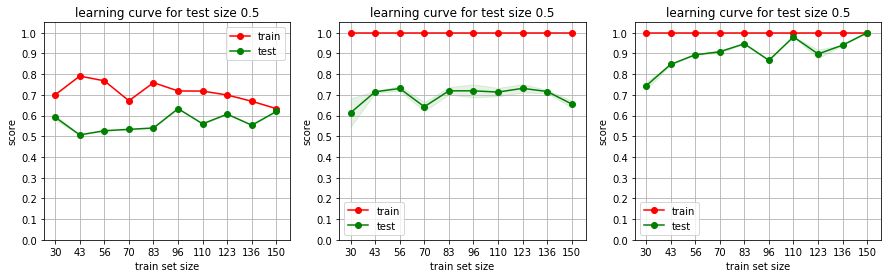

In [21]:
X,y = make_circles(300, noise=.1)
test_size=.5
est1, est2 = DecisionTreeClassifier(max_depth=2), DecisionTreeClassifier(max_depth=15)
train_sizes = np.linspace(.1,.5,10)

plt.figure(figsize=(15,4))
plt.subplot(131)
plot_lc(est1, X,y, train_sizes, test_size, n_reps=10)
plt.subplot(132)
plot_lc(est2, X,y, train_sizes, test_size, n_reps=10)
plt.subplot(133)
X,y = make_circles(300, noise=1e-5)
plot_lc(est2, X,y, train_sizes, test_size, n_reps=10)


juega con distintos valores del ruido en la generación del dataset

Text(0.5,1,'estimator 2 TEST data 0.69')

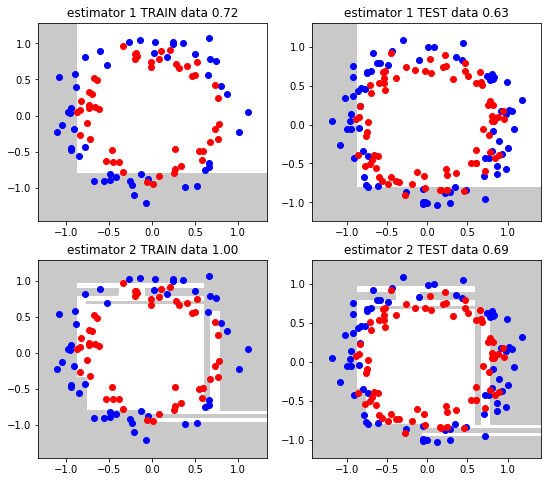

In [17]:
n=300
X,y = make_circles(n, noise=.1)
Xtr, ytr, Xts, yts = X[:n/3], y[:n/3], X[-n/2:], y[-n/2:]
est1.fit(Xtr, ytr);est2.fit(Xtr, ytr)
plt.figure(figsize=(9,8))
plt.subplot(221);plot_2Ddata_with_boundary(est1.predict, Xtr, ytr); plt.title("estimator 1 TRAIN data %.2f"%est1.score(Xtr,ytr))
plt.subplot(222);plot_2Ddata_with_boundary(est1.predict, Xts, yts); plt.title("estimator 1 TEST data %.2f"%est1.score(Xts,yts))
plt.subplot(223);plot_2Ddata_with_boundary(est2.predict, Xtr, ytr); plt.title("estimator 2 TRAIN data %.2f"%est2.score(Xtr,ytr))
plt.subplot(224);plot_2Ddata_with_boundary(est2.predict, Xts, yts); plt.title("estimator 2 TEST data %.2f"%est2.score(Xts,yts))
